In [1]:
import os

In [2]:
!nvidia-smi

Thu Oct  3 22:07:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1B:00.0 Off |                  N/A |
| 27%   32C    P8              26W / 250W |  10973MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [4]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch import nn
import cv2
import pandas as pd
from pylab import imshow
import csv
import torch.nn.functional as F
from torch.utils.data import random_split


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataloading

In [6]:
root = Path().absolute().parent.parent / 'CourseOCRTask3'
assert root.exists(), root.absolute()

In [7]:
train_path = os.path.join(root, 'Train')
test_path = os.path.join(root, 'Test')
markup_path = os.path.join(train_path, 'markup.csv')
images_path = os.path.join(train_path, 'Images')

In [8]:
train_markup = pd.read_csv(markup_path, header=None, encoding='utf-16')
image_paths = []
for i in range(len(train_markup)):
    image_paths.append('/'.join([ images_path, train_markup.iloc[i][0] ]))
train_markup[0] = image_paths
train_markup

,0,1,2,3,4,5,6,7,8,9,10
0,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,3601514743345,538,248,1590,225,1597,663,532,676,1010101111000110101100110111001011001101000110...
1,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,7000001062307,372,433,360,1289,124,1293,147,431,1010001101010011100011010100111000110101100110...
2,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,2250001407126,408,230,1224,229,1224,688,414,683,1010010011011000101001110100111000110101100110...
3,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,10101427156,335,149,1005,155,1005,438,335,447,1010001101001100100011010011001000110100110010...
4,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,2400745402226,469,237,1388,260,1392,712,464,696,1010100011000110101001110010001010001101110010...
...,...,...,...,...,...,...,...,...,...,...,...
8194,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,4823077510083,86,54,622,53,622,202,87,202,1010110111001101101111010001101001000100100010...
8195,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,4823077505386,109,44,664,55,668,206,107,192,1010110111001101101111010001101001000100100010...
8196,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,4823077505492,121,27,704,13,704,168,120,187,1010110111001101101111010001101001000100100010...
8197,/home/krotovan/Alexander/ocr/CourseOCRTask3/Tr...,2010000019696,158,81,165,518,62,521,55,82,1010001101001100101001110100111000110101001110...


In [9]:
train_markup = train_markup.to_numpy()

In [10]:
train_markup[0]

array(['/home/krotovan/Alexander/ocr/CourseOCRTask3/Train/Images/fc272e4092ccb147a31e66bc1d10fbfb.png',
       3601514743345, 538, 248, 1590, 225, 1597, 663, 532, 676,
       '10101011110001101011001101110010110011010001101010100010010111001000010100001010111001001110101'],
      dtype=object)

In [11]:
def open_image_from_markup(info):
    return cv2.imread(info[0])

In [12]:
open_image_from_markup(train_markup[0]).shape

(901, 2129, 3)

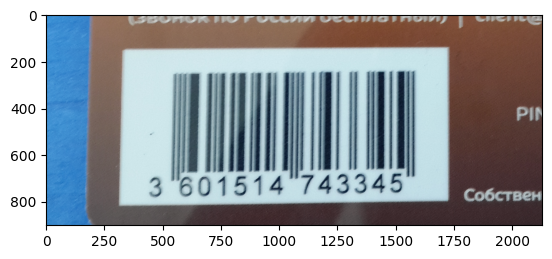

In [13]:
plt.imshow(open_image_from_markup(train_markup[0]));

torch.Size([3, 256, 256])
torch.float32
torch.Size([1, 256, 256])
torch.float32


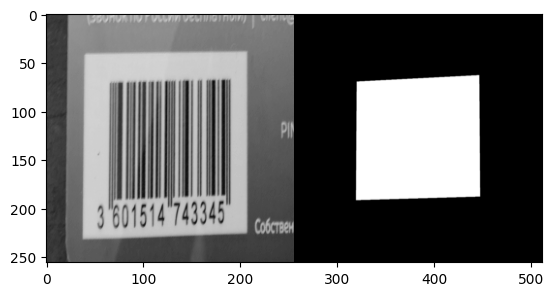

In [14]:
info = train_markup[0]
img = open_image_from_markup(info)

corner_coordinates = np.array(info[2:-1], dtype=np.int32).reshape(4, 2)
mask = cv2.fillConvexPoly(np.zeros(img.shape[:2]), corner_coordinates, 1)

img = transforms.ToTensor()(img)
img = transforms.Resize((256, 256))(img)
mask = transforms.ToTensor()(mask)
mask = transforms.Resize((256, 256))(mask)
mask = mask.float()
print(img.size())
print(img.dtype)
print(mask.size())
print(mask.dtype)
plt.imshow(np.hstack([img.numpy()[0], mask.numpy()[0]]), cmap='gray');

In [15]:
class BCTrainDataset(Dataset):
    def __init__(self, markup):
        self.markup = markup

    def __len__(self):
        return len(self.markup)

    def __getitem__(self, idx):
        info = self.markup[idx]
        img = open_image_from_markup(info)

        corner_coordinates = np.array(info[2:-1], dtype=np.int32).reshape(4, 2)
        mask = cv2.fillConvexPoly(np.zeros(img.shape[:2]), corner_coordinates, 1)
        
        img = transforms.ToTensor()(img)
        img = transforms.Resize((256, 256))(img).to(device)
        
        mask = transforms.ToTensor()(mask)
        mask = mask.float()
        mask = transforms.Resize((256, 256))(mask).to(device)
        return img, mask

In [16]:
dataset = BCTrainDataset(train_markup)
train_dataset, valid_dataset = random_split(dataset, lengths=[0.8, 0.2])
print(len(train_dataset), len(valid_dataset))

6560 1639


In [17]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### Model

https://github.com/milesial/Pytorch-UNet

In [18]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [19]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [21]:
import torch
import lightning
import torchmetrics

class LitClassifier(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = DiceLoss()

    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.001)
        return optimizer

In [22]:
model = UNet().to(device)

In [23]:
lit_model = LitClassifier(model).to(device)
trainer = lightning.Trainer(max_epochs=1)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-10-03 22:07:36.928757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 22:07:37.732845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]

  | Name      | Type     | Params
---------------------------------------
0 | model     | UNet     | 31.0 M
1 | criterion | DiceLoss | 0     
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

/home/krotovan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/krotovan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=1` reached.


### test

In [24]:
def open_image(info):
    return cv2.imread(info)

In [25]:
class BCTestDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = open_image(img_path)
        img_size = img.shape[:-1]
        img = transforms.ToTensor()(img)
        img = transforms.Resize((256, 256))(img).to(device)
        return img, img_size, img_path

In [26]:
test_images_path = os.path.join(test_path, 'Images')
test_images = os.listdir(test_images_path)
test_images_paths = []
for i in range(len(test_images)):
    test_images_paths.append('/'.join([ test_images_path, test_images[i] ]))
test_dataset = BCTestDataset(test_images_paths)

In [27]:
def find_corners(prediction):

    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(contour)
    return np.array(list(map(str,
                    [x, y + h,
                     x, y,
                     x + w, y,
                     x + w, y + h])))

In [28]:
corners = []
image_names = []

model.eval()
model.to(device)
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, img_size, img_path = test_dataset[i]
        prediction = model(img.unsqueeze(0))
        prediction = transforms.Resize((img_size[0], img_size[1]))(prediction)

        corners.append(find_corners(prediction.squeeze()))
        image_names.append(img_path.split('/')[-1])

In [29]:
with open('answer.csv', mode='w', newline='', encoding='utf-16') as file:
    for i in range(len(test_dataset)):
        file.write(image_names[i] + ',-,' + ','.join([ j for j in corners[i] ]) + ',-\n')

In [30]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/krotovan/Alexander/ocr/course_intro_ocr/task3/answer.csv) against markup(/home/krotovan/Alexander/ocr/course_intro_ocr/task3/markup.csv)
recognition_accuracy=0.0
detection_result=0.98
score=0.98
